In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:

df = pd.read_csv("/content/drive/MyDrive/srl_product_review.csv")
df.shape

(8260, 5)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])
sequences = tokenizer.texts_to_sequences(df['Review'])


In [ ]:
checkpoint = ModelCheckpoint("model_srl_BiLstm.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

labels = {'PRED': 1, 'PROD1': 2, 'ASP': 3, 'PROD2': 4}
count = 0
labels_numbered = []
for _, row in df.iterrows():
    m_len = len(sequences[count])+2
    output_sequence = [0] * m_len
    for label, indices in eval(row['Label']).items():

        for index in indices:
            output_sequence[index] = labels[label]

    labels_numbered.append(output_sequence)
    count+=1

max_length = 40
sequences_padded = pad_sequences(sequences, maxlen=max_length, padding='post')
labels_padded = pad_sequences(labels_numbered, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index)
embedding_dim = 200

In [ ]:

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model2.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model2.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

with tf.device('/GPU:0'):

  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
  model.add(Bidirectional(LSTM(units=70, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
  model.add(Dense(units=5, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  X = sequences_padded
  y = labels_padded
  history = model.fit(X, y, epochs=15, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

Default GPU Device: /device:GPU:0
Epoch 1/15
207/207 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.9129
Epoch 1: val_accuracy improved from -inf to 0.92326, saving model to model_srl_BiLstm.h5
207/207 [==============================] - 78s 330ms/step - loss: 0.3422 - accuracy: 0.9129 - val_loss: 0.2160 - val_accuracy: 0.9233
Epoch 2/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


207/207 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9520
Epoch 2: val_accuracy improved from 0.92326 to 0.94193, saving model to model_srl_BiLstm.h5
207/207 [==============================] - 73s 355ms/step - loss: 0.1384 - accuracy: 0.9520 - val_loss: 0.1603 - val_accuracy: 0.9419
Epoch 3/15
207/207 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 0.9638
Epoch 3: val_accuracy improved from 0.94193 to 0.95242, saving model to model_srl_BiLstm.h5
207/207 [==============================] - 56s 269ms/step - loss: 0.1047 - accuracy: 0.9638 - val_loss: 0.1324 - val_accuracy: 0.9524
Epoch 4/15
207/207 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9705
Epoch 4: val_accuracy improved from 0.95242 to 0.95850, saving model to model_srl_BiLstm.h5
207/207 [==============================] - 57s 278ms/step - loss: 0.0869 - accuracy: 0.9705 - val_loss: 0.1197 - val_accuracy: 0.9585
Epoch 5/15
207/207 [=========================

In [ ]:
from keras.layers import Input, Concatenate, Dot, Activation
from keras.models import Model

def attention_model():
    inputs = Input(shape=(max_length,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(inputs)
    lstm = Bidirectional(LSTM(units=64, return_sequences=True))(embedding)
    attention = Dense(1, activation='tanh')(lstm)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(128)(attention)
    attention = Permute([2, 1])(attention)
    sent_representation = Multiply()([lstm, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)
    output = Dense(1, activation='sigmoid')(sent_representation)

    model = Model(inputs=inputs, outputs=output)
    return model

model3 = attention_model()
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


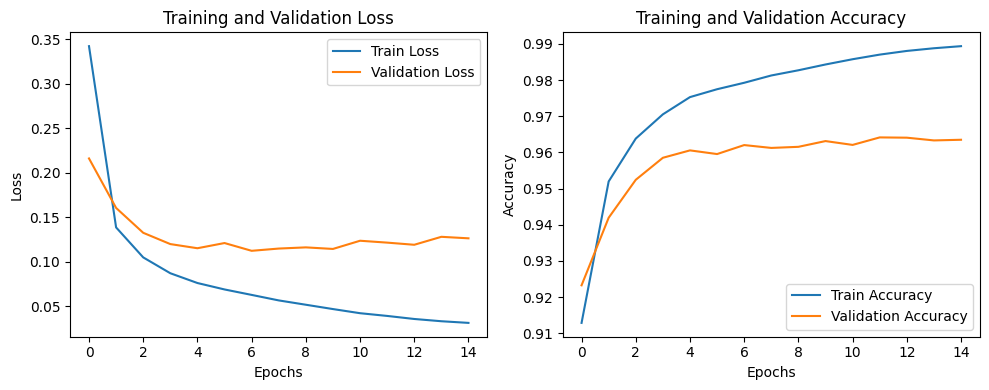

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjusts subplot params so that the subplots fit into the figure area.
plt.show()

In [ ]:

# Step 4: Evaluation (if needed)
validation_df = pd.read_csv("/content/drive/MyDrive/cleaned_srl_product_review.csv")  # Replace "validation_data.csv" with your validation dataset file name
validation_sequences = tokenizer.texts_to_sequences(validation_df['Review'])
max_length = 40
validation_sequences_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post')

validation_labels = {'PRED': 1, 'PROD1': 2, 'ASP': 3, 'PROD2': 4}
count = 0
validation_labels_numbered = []
for _, row in validation_df.iterrows():
    # m_len = len(validation_sequences[count])+5
    m_len = len(validation_sequences_padded[count])
    output_sequence = [0] * m_len
    for label, indices in eval(row['Label']).items():
        # Set the values according to the class
        for index in indices:
            output_sequence[index] = labels[label]

    validation_labels_numbered.append(output_sequence)
    count+=1


validation_labels_padded = pad_sequences(validation_labels_numbered, maxlen=max_length, padding='post')

X_val = validation_sequences_padded
y_val = validation_labels_padded

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


259/259 [==============================] - 9s 35ms/step - loss: 0.0446 - accuracy: 0.9864
Test Loss: 0.04462471231818199
Test Accuracy: 0.9863831996917725


In [ ]:
predictions = model.predict(X_val)

259/259 [==============================] - 7s 25ms/step


In [ ]:
print(X_val.shape, y_val.shape)
predictions.shape


(8260, 40) (8260, 40)


(8260, 40, 5)

In [ ]:
from sklearn.metrics import classification_report

predicted_labels = np.argmax(predictions, axis=2)

true_labels = y_val

predicted_labels_flat = predicted_labels.reshape(-1)
true_labels_flat = true_labels.reshape(-1)

print(true_labels.shape, predictions.shape, predicted_labels.shape)
print(predicted_labels[0], y_val[0])
print(classification_report(true_labels_flat, predicted_labels_flat, labels=[0, 1, 2, 3, 4], target_names=['None', 'PRED', 'PROD1', 'ASP', 'PROD2']))


(8260, 40) (8260, 40, 5) (8260, 40)
[2 0 0 0 1 1 3 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0] [2 0 0 0 1 1 3 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
              precision    recall  f1-score   support

        None       0.99      0.99      0.99    298525
        PRED       0.92      0.90      0.91     10656
       PROD1       0.94      0.95      0.95      7545
         ASP       0.91      0.91      0.91      8520
       PROD2       0.97      0.90      0.93      5154

    accuracy                           0.99    330400
   macro avg       0.95      0.93      0.94    330400
weighted avg       0.99      0.99      0.99    330400



In [ ]:

from keras.models import load_model

loaded_model = load_model("model_srl_BiLstm.h5")


example_sentences = ["Unai Emery's side have won just two of their last five Premier League games, and remain three points off the Champions League places.", " His father was a chauffeur.",
"No leadership in removing the anti-Semites.",
"Doctors are susceptible to other diseases, such as alcoholism and addiction, so why not vaccine hesitancy",
"Its modern spacious suites exude a feeling of calm, with polished wooden floors, faintly Fifties-style furnishings and original artworks.",
"Mike Minor had another solid outing, allowing just one run and five hits in six innings but didn't figure into the decision. He struck out five and walked two. Calhoun's 10th homer of the season was the first hit Minor allowed after retiring the first six batters."
]

for example_sentence in example_sentences:
    example_sequence = tokenizer.texts_to_sequences([example_sentence])

    example_sequence_padded = pad_sequences(example_sequence, maxlen=max_length, padding='post')

    predicted_labels = np.argmax(loaded_model.predict(example_sequence_padded),axis=-1)
    print(predicted_labels)
